In [ ]:
##### DO NOT EDIT THIS CELL!!!
##### DO NOT IMPORT ANY ADDITIONAL PACKAGES

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
%matplotlib inline

#from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import applications

In [ ]:
# https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet
ds_name = 'oxford_iiit_pet:4.0.0'
input_shape = (None, None, 3)

In [ ]:
# https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet
ds_name = 'oxford_iiit_pet:3.*.*' # 'oxford_iiit_pet'
input_shape = (None, None, 3)

FeaturesDict({
    'file_name': Text(shape=(), dtype=string),
    'head_bbox': BBoxFeature(shape=(4,), dtype=float32),
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
    'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
    'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
})
37
['Abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'Bengal', 'Birman', 'Bombay', 'boxer', 'British_Shorthair', 'chihuahua', 'Egyptian_Mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'Maine_Coon', 'miniature_pinscher', 'newfoundland', 'Persian', 'pomeranian', 'pug', 'Ragdoll', 'Russian_Blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'Siamese', 'Sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(TensorShape([500, 500, 3]), TensorShape([500, 500, 1]))

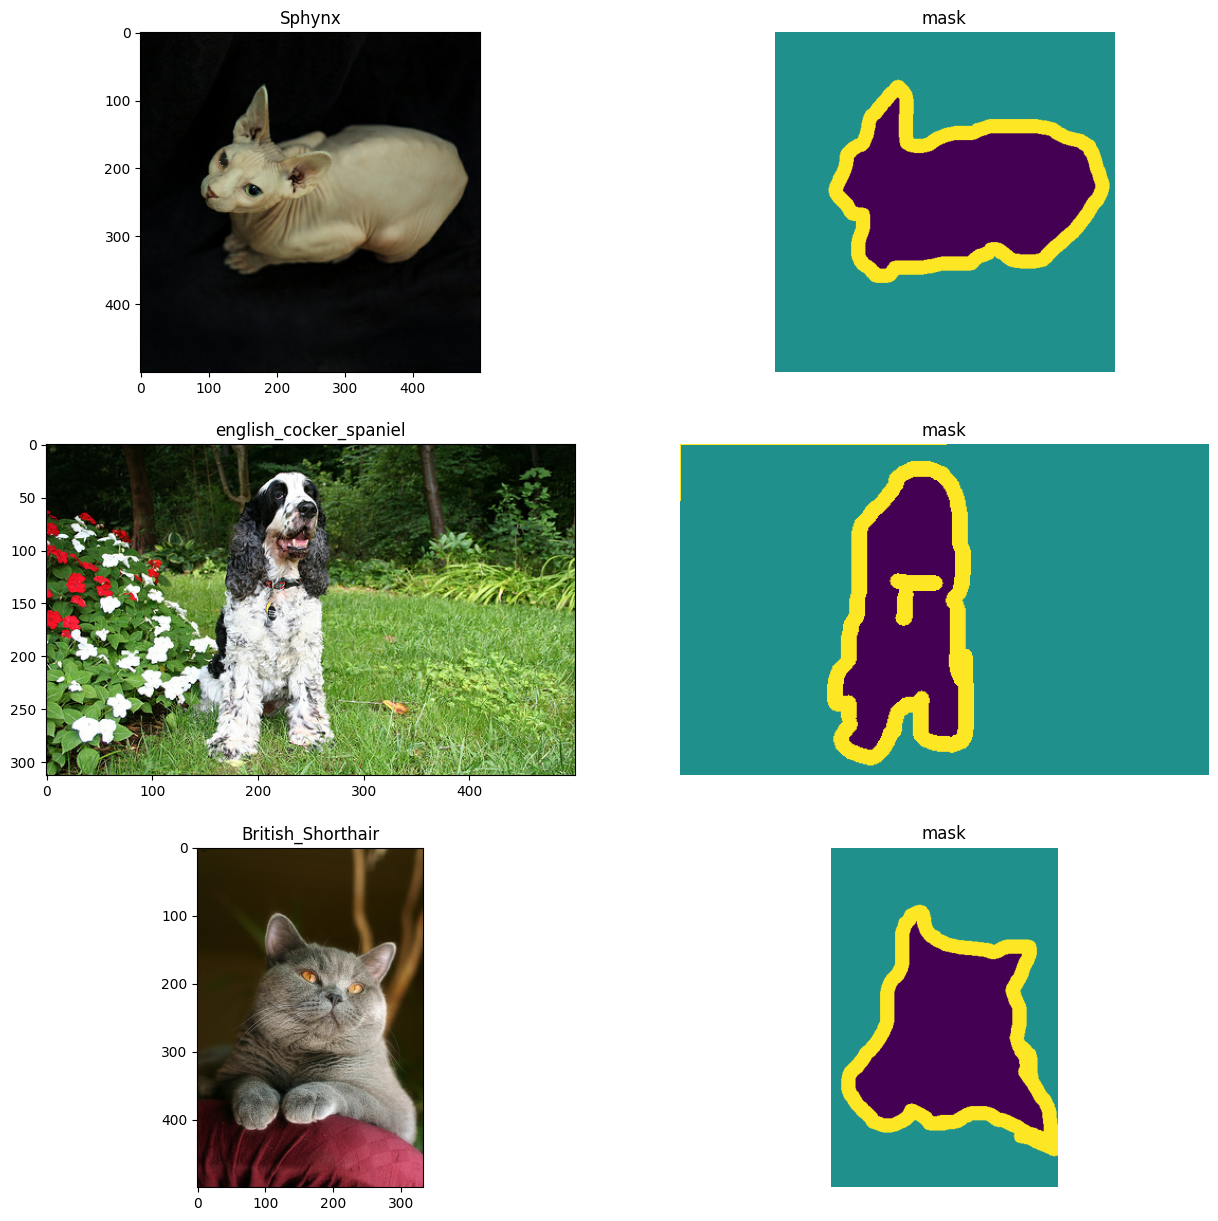

In [ ]:
##### DO NOT EDIT THIS CELL!!!

# load dataset
# code adapted from https://www.tensorflow.org/tutorials/images/segmentation

(train_ds, val_ds, test_ds), metadata = tfds.load(
    # more datasets: https://www.tensorflow.org/datasets/catalog/overview#all_datasets
    name=ds_name,
    # more info: https://www.tensorflow.org/datasets/splits
    split=['train', 'test[:75%]', 'test[75%:]'],
    # return metadata
    with_info=True,
    # download data
    download=True,
    # whether to shuffle the files between each epoch
    shuffle_files=False,
)

print (metadata.features)

# num classes
num_classes = metadata.features['label'].num_classes
print (num_classes)

# class labels
class_names = metadata.features['label'].names
print (class_names)

plt.figure(figsize=(15, 15))
i = 0
for datapoint in train_ds.take(3):
    label = datapoint['label']
    image = datapoint['image']
    mask = datapoint['segmentation_mask']
    ax = plt.subplot(3, 2, i + 1)
    plt.title(class_names[label])
    plt.imshow(image.numpy().astype("uint8"))
    ax = plt.subplot(3, 2, i + 2)
    plt.title('mask')
    plt.imshow(mask.numpy().astype("uint8"))
    plt.axis("off")
    i = i + 2

# get shape of images and masks
iter(train_ds).get_next()['image'].shape, iter(train_ds).get_next()['segmentation_mask'].shape

In [ ]:
##### DO NOT EDIT THIS CELL!!!

# configure dataset for performance
# code adapted from https://www.tensorflow.org/guide/data_performance
from tensorflow.keras.layers import Resizing
IMG_SIZE = 128
batch_size = 64
BUFFER_SIZE = 1000
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, resize=False, normalize=False, augment=False):

    # Extract just image and segmentation_mask
    ds = ds.map(lambda x: (x['image'], x['segmentation_mask']))

    # Resize dataset
    if resize:
        resizing = Resizing(IMG_SIZE,IMG_SIZE)
        ds = ds.map(lambda image, mask: (resizing(image), resizing(mask)))

    # Augment dataset (should only be applied to training data)
    if augment:
        ds = ds.map(lambda image, mask: (tf.image.flip_left_right(image), tf.image.flip_left_right(mask)) if tf.random.uniform(()) > 0.5 else (image, mask))

    # Normalize dataset
    if normalize:
        # image will now have values 0-1 (instead of 0-255)
        # mask will now have values 0, 1, 2 (instead of 1, 2, 3)
        ds = ds.map(lambda image, mask: (image/255.0, mask-1))

    # Batch dataset
    # Note: To be batched, images need to share the same height and width.
    #          So if dataset has images of different sizes, resize them before batching
    ds = ds.batch(batch_size)

    # The first time the dataset is iterated over, its elements will be cached either in the specified file or in memory;
    #   subsequent iterations will use the cached data.
    #   Note: cache will produce exactly the same elements during each iteration through the dataset;
    #     if you wish to randomize the iteration order, make sure to call shuffle after calling cache.
    ds = ds.cache()

    # Shuffle the data.
    #   buffer_size: this dataset fills a buffer with buffer_size elements, then randomly samples elements from this buffer,
    #     replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to
    #     the full size of the dataset is required.
    if shuffle:
        ds = ds.shuffle(BUFFER_SIZE, seed=None)

    # Prefetching overlaps the preprocessing and model execution of a training step.
    #   While the model is executing training step s, the input pipeline is reading the data for step s+1
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare(train_ds, shuffle=True, resize=True, normalize=True, augment=True)
val_ds = prepare(val_ds, resize=True, normalize=True)
test_ds = prepare(test_ds, resize=True, normalize=True)

# get shape of images and masks
iter(train_ds).get_next()[0].shape, iter(train_ds).get_next()[1].shape

(TensorShape([64, 128, 128, 3]), TensorShape([64, 128, 128, 1]))

In [ ]:
##### THIS IS THE ONLY CELL YOU WILL EDIT PER THE ISNTRUCTIONS BELOW

### downsampling path - VGG16
backbone = applications.VGG16(input_shape=(128, 128, 3), include_top=False)
backbone.trainable = False
down1 = backbone.get_layer('block1_pool').output
down2 = backbone.get_layer('block2_pool').output
down3 = backbone.get_layer('block3_pool').output
down4 = backbone.get_layer('block4_pool').output
down5 = backbone.get_layer('block5_pool').output


### (1.1) Upsampling Block 1
up1 = layers.Conv2DTranspose(512, (3, 3), strides=2, padding='same', activation='relu')(down5)
up1 = layers.BatchNormalization()(up1)
up1 = layers.Concatenate()([up1, down4])

### (1.2) Upsampling Block 2
up2 = layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same', activation='relu')(up1)
up2 = layers.BatchNormalization()(up2)
up2 = layers.Concatenate()([up2, down3])

### (1.3) Upsampling Block 3
up3 = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu')(up2)
up3 = layers.BatchNormalization()(up3)
up3 = layers.Concatenate()([up3, down2])

### (1.4) Upsampling Block 4
up4 = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(up3)
up4 = layers.BatchNormalization()(up4)
up4 = layers.Concatenate()([up4, down1])

### (1.5) Upsampling Block 5 (Final)
up5 = layers.Conv2DTranspose(num_classes, (3, 3), strides=2, padding='same', activation='relu')(up4)

### (1.6) Create Model
model = models.Model(inputs=backbone.input, outputs=up5)

### (1.7) Compile Model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
%%time

##### DO NOT EDIT THIS CELL!!!

# train the model
epochs = 7
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/7
58/58 ━━━━━━━━━━━━━━━━━━━━ 1933s 33s/step - accuracy: 0.4894 - loss: 1.9421 - val_accuracy: 0.8137 - val_loss: 0.5897
Epoch 2/7
58/58 ━━━━━━━━━━━━━━━━━━━━ 1859s 32s/step - accuracy: 0.8424 - loss: 0.3883 - val_accuracy: 0.8470 - val_loss: 0.3868
Epoch 3/7
58/58 ━━━━━━━━━━━━━━━━━━━━ 1850s 32s/step - accuracy: 0.8658 - loss: 0.3278 - val_accuracy: 0.8493 - val_loss: 0.3709
Epoch 4/7
58/58 ━━━━━━━━━━━━━━━━━━━━ 1912s 33s/step - accuracy: 0.8782 - loss: 0.2941 - val_accuracy: 0.8519 - val_loss: 0.3702
Epoch 5/7
58/58 ━━━━━━━━━━━━━━━━━━━━ 1876s 32s/step - accuracy: 0.8850 - loss: 0.2754 - val_accuracy: 0.8599 - val_loss: 0.3435
Epoch 6/7
58/58 ━━━━━━━━━━━━━━━━━━━━ 1851s 32s/step - accuracy: 0.8941 - loss: 0.2502 - val_accuracy: 0.8676 - val_loss: 0.3330
Epoch 7/7
58/58 ━━━━━━━━━━━━━━━━━━━━ 1840s 32s/step - accuracy: 0.9042 - loss: 0.2244 - val_accuracy: 0.8686 - val_loss: 0.3393
CPU times: user 5h 47min 38s, sys: 21min 56s, total: 6h 9min 35s
Wall time: 3h 39min 23s


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


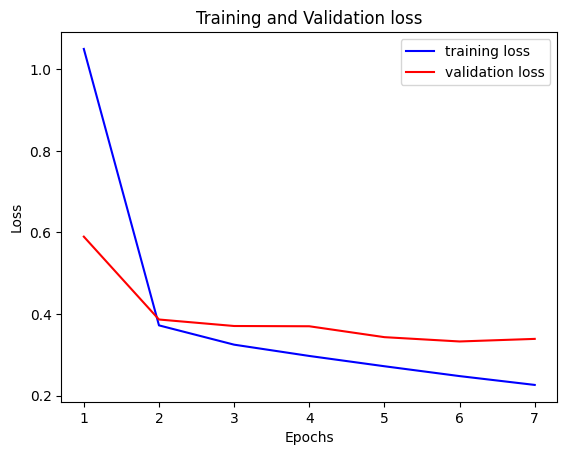

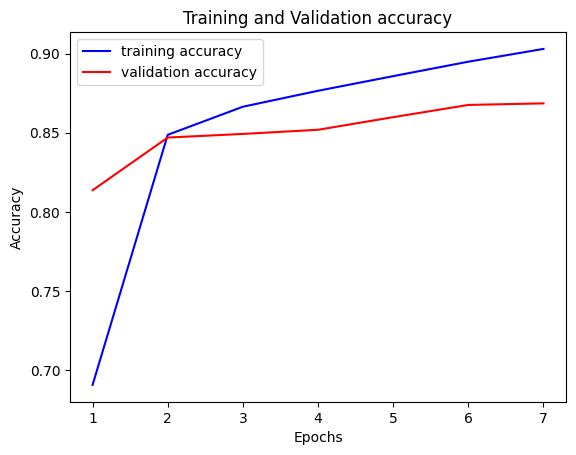

In [ ]:
##### DO NOT EDIT THIS CELL!!!

# model.fit() returns a History object that contains a dictionary with everything that happened during training
# we can use it to plot training/validation loss and training/validation accuracy
history_dict = history.history
print (history_dict.keys())

# plot total loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot accuracy for clshead
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='training accuracy')
plt.plot(epochs, val_acc, 'r', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
##### DO NOT EDIT THIS CELL!!!

# make predictions
# code adapted from https://www.tensorflow.org/tutorials/images/segmentation

plt.figure(figsize=(15, 15))
i = 0
for image, mask in test_ds.take(3):

    ax = plt.subplot(3, 3, i + 1)
    plt.title('image')
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image[0]))

    ax = plt.subplot(3, 3, i + 2)
    plt.title('mask')
    plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[0]))

    ax = plt.subplot(3, 3, i + 3)
    plt.title('pred_mask')
    pred_mask = model.predict(image)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask[0]))

    plt.axis("off")
    i = i + 3

ValueError: too many values to unpack (expected 2)

<Figure size 1500x1500 with 0 Axes>